# Author: Blai Ras
# Time Series Pre-processing for model building

### From the master thesis

### <center>  _'Accuracy comparison between Sparse Autoregressive and XGBoost models for high-dimensional product sales forecasting'_ </center>

In this notebook we present the mandatory steps to adapt our dataset to the needed format, as well as other time series pre-processings. All the needed documentation and detailed description can be found in the thesis paper.

## Needed libraries

In [1]:
import pandas as pd #Tabular data managing
import numpy as np #Vector and array managing
import matplotlib.pyplot as plt #For plotting purposes
from statsmodels.tsa.stattools import adfuller #Needed for the ADF test
import itertools #For the dates expanding operation 
%matplotlib inline

## Data Reading

``Sales`` contain all the sales records of each SKU for each date. ``MD`` means 'Master Data', and works like a dictionary in order to assign a segment to each SKU. ``Promo`` contains all the records of promotions of each SKU for each date.

In [2]:
sales = pd.read_csv("Data/Original Data/Sales.csv",sep=";")
sales = sales.drop(["Country"],axis=1)
md = pd.read_csv("Data/Original Data/MD.csv",index_col=0)[["SKU","Segment"]]
promo = pd.read_csv("Data/Original Data/Promo.csv",index_col=0)[["SKU","Discount","Week","Duration","Marketing_Channel","Position"]]

In order to get the Segment column to our sales records, we merge the ``MD`` and ``Sales`` datasets.

In [3]:
sales = pd.merge(sales,md,on="SKU")
#sales.to_csv("Data/Original_sales.csv",index=None)

## Date formatting

The ``Date`` column is in week format, i.e., ``2015-48``, where 48 is the week number of the year 2015. We need to change it to a normal date format, adding the number of the first day of the week (monday). The function ``toDate`` manages this process.

In [4]:
import datetime
def toDate(string):
    year,week = string.split("-")
    return datetime.date.fromisocalendar(int(year), int(week), 1)

Parsing to type ``datetime``

In [5]:
sales["Date"] = sales["Week"].apply(toDate)
sales["Date"] = sales.Date.astype('datetime64[ns]')
promo["Date"] = promo["Week"].apply(toDate)
promo["Date"] = promo.Date.astype('datetime64[ns]')

In [6]:
sales.head()

,SKU,Week,Sales,Segment,Date
0,444646,2015-48,29,10100,2015-11-23
1,444646,2016-06,74,10100,2016-02-08
2,444646,2016-27,83,10100,2016-07-04
3,444646,2017-11,42,10100,2017-03-13
4,444646,2017-45,57,10100,2017-11-06


## Date Expansion

Since we know there are missing sales and therefore missing weeks in some SKU sales records, this function gathers the oldest and newest date and creates the full expand of datetimes, so we can later on merge with our sales records and define the missing values.

In [35]:

def span_dates(data):
    #Getting the oldest and newest dates
    minDate = data["Date"].min()
    maxDate = data["Date"].max()
    
    #Span creation
    span = pd.date_range(minDate, maxDate, freq="W-MON")
    
    #Dictionary of dates for each SKU
    span_values = {"SKU": list(data["SKU"].unique()), "Date": span}
    
    #Creating each combination
    rows = itertools.product(*span_values.values())
    
    #And finally creating the overall dataset with date and SKU.
    dataExtended = pd.DataFrame.from_records(rows, columns=span_values.keys())
    
    return dataExtended
    

## Flag missing sales

This function creates the column "Missing" which indicates when we have missing sales if and always if there has been already sales of that same product. Those are the sales we need to interpolate from the data!

In [36]:
def flag_missing(data, span):
    
    data["Date"] = data.Date.astype('datetime64[ns]')

    df = pd.merge(span,data,how="left",left_on=["SKU","Date"],right_on=["SKU","Date"])
    df["Week"] = df["Date"].dt.week
    
    df['Cumsum'] = df.groupby('SKU')['Sales'].expanding().sum().reset_index(0, drop=True)
    
    df["Dissapeared"] = 0
    df.loc[(df["Cumsum"]!=0.) & (df["Cumsum"].notna()) & (df["Sales"].isna()),"Dissapeared"] = 1
    
    return df
    

This function performs the split between these missing sales and the ones that are not.

In [37]:
def split_existant(series):
    nonExistant = (series["Dissapeared"] == 0) & (series["Sales"].isna())
    return series[nonExistant], series[~nonExistant]

## Variable Plotting

Just for testing purposes, this function is able to plot a time-series

In [41]:
def plot_series(series,title):
    
    #Sort by date so our 'line' does not go back in time
    series =  series.sort_values("Date")
    
    #The column date now is converted as dataframe index
    if series.index.name != 'Date':
        series = series.set_index("Date")
    
    #Resetting index
    _ = series.copy()
    _.reset_index(level=0, inplace=True)

    #Gathering the oldest and newest date
    min_date = _["Date"].min()
    max_date = _["Date"].max()
    
    #Plot configurations
    plt.figure(figsize=(12,6))
    plt.plot(series, color='red')
    plt.title(title, fontsize=16)

    #Adding a vertical line that helps identifiying when does a year start and end,
    for year in range(min_date.year, max_date.year+1):
        plt.axvline(datetime.datetime(year,1,1), linestyle='-', color='k', alpha=1)
        #And also a vertical stripped line that separates each month
        for month in range(1,13):
            plt.axvline(datetime.datetime(year,month,1), linestyle='--', color='k', alpha=0.1)
            
    #Limiting the x axis according to our date span
    plt.xlim(datetime.datetime(min_date.year,min_date.month,1),max_date)
    plt.show()
    

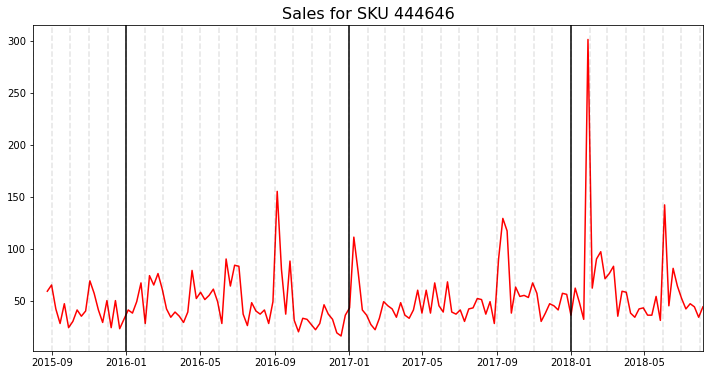

In [38]:
#Example of function call
example_sku = 444646
plot_series(sales[sales.SKU==example_sku][["Sales","Date"]],'Sales for SKU '+str(example_sku))

## Missing Values Management

This function iterates product after product counting NaN values. If this number of missing values is superior to a certain percentage, this product is rejected. 

If not, we still need to interpolate the missing sales, if any.

In [12]:
def nan_management(data,percentage,interpolate,verbose=False):
    
    #List of unique products
    variables = data.SKU.unique()
    #Dataframe where we will be adding the adapted time series
    transformed = pd.DataFrame()
    #NaN counter
    total_nan = 0

    for var in variables:
        #Get the product sales from the overall dataset
        product = data[data.SKU == var][["SKU","Date","Sales","Week","Dissapeared"]]
        
        #Get all the NaN that might have
        nan = product.Sales.isna().sum()
        total_nan += nan
        
        #Check if the product passes our threshold of maximum amount of permitted NaN's
        if nan/product.shape[0] < percentage:
            
            # Split by NaN type
            nonExistant, serie = split_existant(product)

            
            serie = serie.set_index("Date")
            #For testing purposes, we can plot the SKU sales
            if verbose:
                print("\nSKU:",var)
                plot_series(serie[["Sales"]],'Sales for SKU '+str(var))
            
            #Interpolation procedure:
            if interpolate:
                serie["Sales"] = serie["Sales"].interpolate(method='linear')
                #For testing purposes, we can plot the SKU sales once interpolted to see the difference
                if verbose:
                    plot_series(serie[["Sales"]],'Interpolated Sales for SKU '+str(var))
            
            #Undo the date as index
            serie.reset_index(inplace=True)
            
            #Concatenate again the sales records, splitted due the NaN type differentation
            transformed = pd.concat([transformed,pd.concat([nonExistant,serie],ignore_index=True)],ignore_index=True)

    return transformed,total_nan

## Train & Test split

This function tabulates the data in a way that we have firstly the Date as the index, and, secondly, the sales of the product, its discounts and its promotion duration as as columns.

Then, it performs the train and test splitting such that the last 4 weeks are saved for testing purposes and the other records as train set.

This function is parametrized such that we can perform the splitting with or without promotions.

In [13]:
def train_test_split(series,promo,segment,operation):
    
    #Check firstly if there's the promotion dataset
    if len(promo.index) != 0:
            
        #Date type setting
        series["Date"] = series.Date.astype('datetime64[ns]')
        
        #Merging sales with promotions by SKU
        merged = pd.merge(series,promo,on=["SKU","Date"],how="left")

        #Tabulation of each dataset
        #Sales
        sales = pd.crosstab(index=merged['Date'], columns=merged['SKU'],values=merged["Sales"],aggfunc="sum")
        sales.rename(columns=lambda x: 'Sales_' + str(x), inplace=True)
        
        #Discount
        discount = pd.crosstab(index=merged['Date'], columns=merged['SKU'],values=merged["Discount"],aggfunc="sum")
        discount.rename(columns=lambda x: 'Discount_' + str(x), inplace=True)
        
        #Duration
        duration = pd.crosstab(index=merged['Date'], columns=merged['SKU'],values=merged["Duration"],aggfunc="sum")
        duration.rename(columns=lambda x: 'Duration_' + str(x), inplace=True)
        
        #Concatenating our two promotion variables: discounts and duration
        promo = pd.concat([discount,duration],axis=1)

        #Check if after cleaning has no promotion or discount (all zeros)
        if not (len(np.unique(promo))==1 and np.unique(promo)[0] == 0):
            
            #Concatenation now sales with promotion
            concatenation = pd.concat([sales,discount,duration],axis=1)
            
            #Train & Test splitting
            #Train
            concatenation.head(-4).to_csv("Data/"+operation+" Train & Test Sets/"+str(segment)+"Train.csv")
            #Test
            concatenation.tail(4).to_csv("Data/"+operation+" Train & Test Sets/"+str(segment)+"Test.csv")
            
    #If there's no promotion, we just tabulate our sales and perform the splitting
    else:
        sales = pd.crosstab(index=series['Date'], columns=series['SKU'],values=series["Sales"],aggfunc="sum")
        sales.rename(columns=lambda x: 'Sales_' + str(x), inplace=True)
        
        #Train
        sales.head(-4).to_csv("Data/"+operation+" Train & Test Sets/No_Promo/"+str(segment)+"Train.csv")
        #Test
        sales.tail(4).to_csv("Data/"+operation+" Train & Test Sets/No_Promo/Test"+str(segment)+"Test.csv")

## First preprocess: NaN Values

This function applies the explained NaN removal procedure, and saves each segment train & test splits. It also saves the whole Master Data after the removal.

In [14]:
def apply_nan(sales,promo,percentage=0.3,verbose=False):
    
    #Dataframe where we will be adding the pre-processed sales
    new_sales = pd.DataFrame()
    
    #NaN counter
    total_nan = 0
    
    #SKU removal counter
    total_removed = 0
    
    #For each segment
    for i in sales.Segment.unique():
        segment = sales[sales["Segment"] == i][["SKU","Sales","Date"]]
        
        #Expand its dates
        span = span_dates(segment)
        
        #Split by NaN type
        data = flag_missing(segment,span)
        
        #Negative sales (human errors) are set to zero
        data["Sales"] = np.where(data["Sales"] < 0, 0, data["Sales"])
        before = data.SKU.nunique()
        
        if verbose:
            print("SEGMENT:",i)
            print("\tNumber of SKU's before:",data.SKU.nunique())
        
        #NaN management
        adapted,nan = nan_management(data.copy(),
                                 percentage=percentage,
                                 interpolate=True,
                                 verbose=False)
        total_nan += nan
        
        #Recovering the segment ID
        adapted["Segment"] = i
        
        #Check if we deleted all the SKU's of the segment
        if len(adapted.index) !=0:
            
            after = adapted.SKU.nunique()
            total_removed += before-after
            if verbose:
                print("\tNumber of SKU's After:",adapted.SKU.nunique())
                print("\tPercentage of removed SKU's:",round((after/before)*100,2))
            
            #If more than 10 SKU's remain, the segment is valid.
            if adapted.SKU.nunique() > 10:
                new_sales = pd.concat([new_sales,adapted])
                
                #Perform the train & test splitting
                train_test_split(adapted,promo,i,operation="Raw")ç
        else:
            if verbose:
                print("This segment is eliminated due that all SKU's have been removed")
                
    #Overall interesting info
    if verbose:
        print("Total amount of NaN values:",total_nan)
        print("Total amount of removed SKU's:",total_removed)
    
    #Replace the final "valid" NaN values with zero
    new_sales["Sales"] = new_sales["Sales"].fillna(0)
    
    #And save all the valid sales dataset
    new_sales.to_csv("Data/All_Sales_After_Cleaning.csv",index=None)
    return new_sales

In [32]:
new_sales = apply_nan(sales,promo,percentage=0.3,verbose=True)

SEGMENT: 10100
	Number of SKU's before: 2
	Number of SKU's After: 1
	Percentage of removed SKU's: 50.0
SEGMENT: 11900
	Number of SKU's before: 2
	Number of SKU's After: 1
	Percentage of removed SKU's: 50.0
SEGMENT: 10150
	Number of SKU's before: 1014
	Number of SKU's After: 511
	Percentage of removed SKU's: 50.39
SEGMENT: 11928
	Number of SKU's before: 84
	Number of SKU's After: 81
	Percentage of removed SKU's: 96.43
SEGMENT: 10180
	Number of SKU's before: 142
	Number of SKU's After: 114
	Percentage of removed SKU's: 80.28
SEGMENT: 11908
	Number of SKU's before: 395
	Number of SKU's After: 359
	Percentage of removed SKU's: 90.89
SEGMENT: 10160
	Number of SKU's before: 351
	Number of SKU's After: 44
	Percentage of removed SKU's: 12.54
SEGMENT: 11956
	Number of SKU's before: 133
	Number of SKU's After: 11
	Percentage of removed SKU's: 8.27
SEGMENT: 11954
	Number of SKU's before: 143
	Number of SKU's After: 85
	Percentage of removed SKU's: 59.44
SEGMENT: 11916
	Number of SKU's before: 116

## Second preprocess: Stationarity 

In this second preprocess measure we check for stationary time series

In [15]:
new_sales = pd.read_csv("Data/All_Sales_After_Cleaning.csv")
new_sales.head()

,SKU,Date,Sales,Week,Dissapeared,Segment
0,447010,2015-08-24,12.0,35,0,10150
1,447010,2015-08-31,21.0,36,0,10150
2,447010,2015-09-07,23.0,37,0,10150
3,447010,2015-09-14,11.0,38,0,10150
4,447010,2015-09-21,18.0,39,0,10150


This function performs the first differentation of a time series, making it stationary.

In [16]:
def remove_trend(series):
    return series.diff().dropna()

This function iterates all the sales of all the products and test them with the Augmented Dickey-Fuller test in order to know if they are stationary or not. 

As mentioned in the paper, we will first-differentiate all the time series even if they pass or not the ADF test. 

In [25]:
def preprocess(serie):
    #List of SKU's
    variables = serie.SKU.unique()
    
    #Counters
    originalADF = 0
    no_pass= 0
    
    #Dataframe were we will store the first-differenciated series
    processed = pd.DataFrame()
    
    for var in variables:
        product = serie[serie.SKU == var][["SKU","Date","Sales"]]
        product = product.sort_values("Date")
        
        #Perform the ADF test
        result = adfuller(product["Sales"])
        
        #Check the p-value for info purposes
        if result[1] >= 0.05:
            originalADF +=1
        
        #Apply the first-differentiation
        product["Sales"] = remove_trend(product["Sales"])
        
        #Due to the first-differentiation, we lose the first value (a NaN)
        product = product.tail(-1)
        
        #Test again if our series is stationary
        result = adfuller(product["Sales"])
        if result[1] >= 0.05:
            no_pass +=1
        
        #Save the new time serie
        processed = pd.concat([processed,product])
    return originalADF,no_pass,processed

This function manages the overall process of first-differentiate our time series and then performs the train & test splitting. 

It is parametrized in order to be able to choose if we want to apply the first-differentiation or not.

In [26]:
def apply_preprocess(sales,promo,do_preprocess,verbose=False):
    
    #Counters
    original_no = 0
    no = 0
    
    for i in sales.Segment.unique():
        segment = sales[sales["Segment"] == i][["SKU","Sales","Date"]]
        
        #Apply or not the first-differentiation
        if do_preprocess:
            originalADF,no_pass,processed = preprocess(segment)
            original_no += originalADF
            no = no_pass + no
            
            #Train & test split
            train_test_split(processed,promo,i,operation="Processed")
            
        else:
            train_test_split(segment,promo,i,operation="Raw")
            
    if verbose:
        print("\tTotal variables that didn't pass the Augmented Dickey–Fuller test:",original_no)
        print("\tTotal variables that didn't pass the Augmented Dickey–Fuller test after differenciating:",no)

In [27]:
apply_preprocess(new_sales,promo,do_preprocess=True,verbose=True)

	Total variables that didn't pass the Augmented Dickey–Fuller test: 1190
	Total variables that didn't pass the Augmented Dickey–Fuller test after differenciating: 3
